In [2]:
# environment setup
from matplotlib import pyplot as plt
import pandas as pd
from openbabel import openbabel as ob
from scipy.stats import norm, linregress
import numpy as np
import sys; sys.path.append("/home/shachar/repos/miscellaneous/CodStructures/")
import utils
from featurizers import StructurePropertyFeaturizer
from read_to_sql import StructureProperty, Substituent
# creating session with SQL database
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
engine = create_engine("sqlite:///{}".format("/home/shachar/repos/miscellaneous/CodStructures/main.db"))
session = sessionmaker(bind=engine)()
utils.define_pallet()
plt.rcParams["figure.facecolor"] = "#F2F2F2"
plt.rcParams["axes.facecolor"] = "#F2F2F2"
plt.rcParams["savefig.facecolor"] = "#F2F2F2"

In [3]:
# setting up important global variables & functions

def non_planarity_modes(session):
    names = session.query(StructureProperty.property).distinct().all()
    return [x[0] for x in names if "non planarity" in x[0]]

def homa_properties(session, target="homa"):
    names = session.query(StructureProperty.property).filter(StructureProperty.source == "homa").distinct().all()
    return [x[0] for x in names if target in x[0]]

def homa_values_df(session, sids, target, avg_pyrroles):
    # reading the data from SQL
    homa_props = homa_properties(session, target=target)
    units = [None for _ in range(len(homa_props))]
    feat = StructurePropertyFeaturizer(homa_props, units, navalue=None)
    homa_df = pd.DataFrame(data=feat.featurize(session, sids), columns=feat.feature_names, index=sids)
    homa_df.columns = [c.split(" ")[0] for c in homa_df.columns]
    if avg_pyrroles:
        # adding column of average pyrrole HOMA score
        pyrrole_cols = [c for c in homa_df.columns if "pyrrole" in c]
        homa_df["pyrrole"] = homa_df[pyrrole_cols].mean(axis=1)
        # removing all other pyrrole columns
        homa_df = homa_df[[c for c in homa_df.columns if not c in pyrrole_cols]]
    return homa_df

def non_planarity_df(session, sids, units, add_total_non_planarity):
    # reading the data
    modes = non_planarity_modes(session)
    # removing wavingy2 mode as it exists only in corroles
    modes.remove("wavingy2 non planarity")
    mode_units = [units for _ in range(len(modes))]
    if add_total_non_planarity:
        modes.append("total out of plane (exp)")
        mode_units.append("A")
    feat = StructurePropertyFeaturizer(modes, mode_units, navalue=None)
    return pd.DataFrame(data=feat.featurize(session, sids), columns=feat.feature_names, index=sids)

def scatter_plot(x, y, ax=None, xname=None, yname=None, add_fitted_line=False, add_ideal_line=False, label=None):
    if ax is None:
        ax = plt.gca()
    ax.scatter(x, y, label=label)
    if xname is not None:
        ax.set_xlabel(xname)
    if yname is not None:
        ax.set_ylabel(yname)
    if add_fitted_line:
        a, b = np.polyfit(x, y, deg=1)
        fitted_x = [min(x), max(x)]
        fitted_y = [a * v + b for v in fitted_x]
        ax.plot(fitted_x, fitted_y, "r--")
    if add_ideal_line:
        fitted_x = [min(x), max(x)]
        ax.plot(fitted_x, fitted_x, "r--")

def p_value(sample_data, population_data):
    """Calculate the p-value of sample from normal distribution. calculates the probability that the mean difference between the sample and the population is at least as large as measured."""
    sample_mean = np.mean(sample_data)
    population_mean = np.mean(population_data)
    population_std = np.std(population_data)
    N = len(sample_data)
    statistic = abs((sample_mean - population_mean) / (population_std / np.sqrt(N)))
    return 2 * norm(0, 1).sf(statistic)

def metal_radius(session, sid: int):
    """Get the VDW radius of the metal center"""
    metal = session.query(Substituent.substituent).filter(Substituent.structure == sid).filter(Substituent.position == "metal").all()[0][0]
    metal = utils.mol_from_smiles(metal).GetAtom(1)
    return [ob.GetVdwRad(metal.GetAtomicNum())]


# Basic analysis

analysing histograms and general correlations


In [8]:
por_sids = utils.sids_by_type(session, "porphyrin")
cor_sids = utils.sids_by_type(session, "corrole")
all_sids = utils.sids_by_type(session, "all")
all_homa = homa_values_df(session, all_sids, "homa", True)
cor_homa = homa_values_df(session, cor_sids, "homa", True)
cor_en = homa_values_df(session, cor_sids, "en", True)
cor_geo = homa_values_df(session, cor_sids, "geo", True)
por_homa = homa_values_df(session, por_sids, "homa", True)
por_en = homa_values_df(session, por_sids, "en", True)
por_geo = homa_values_df(session, por_sids, "geo", True)

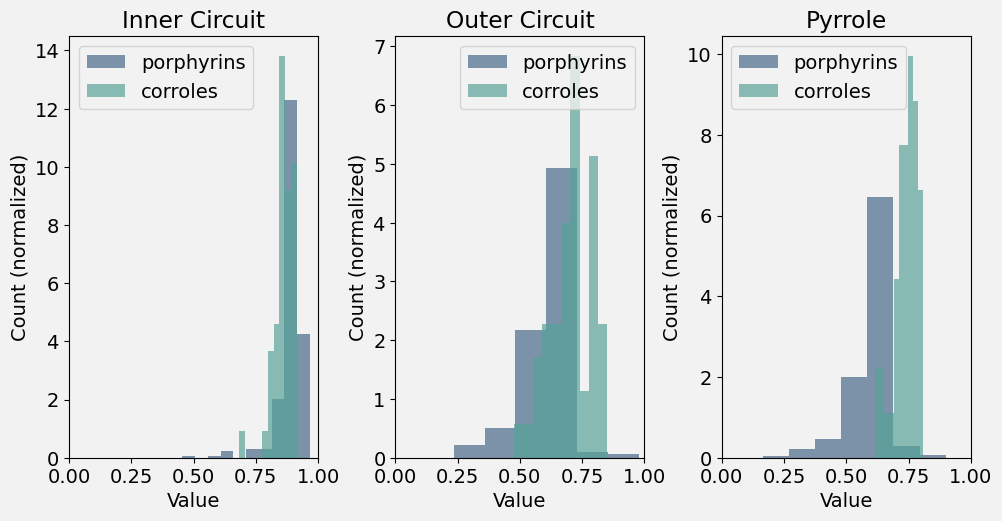

In [23]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))
fig.tight_layout()
for i, c in enumerate(por_homa.columns):
    axs[i].hist(por_homa[c], density=True, alpha=0.7, label="porphyrins")
    axs[i].hist(cor_homa[c], density=True, alpha=0.7, label="corroles")
    axs[i].set_title(" ".join(c.split("_")).title())
    axs[i].legend()
    axs[i].set_xlabel("Value")
    axs[i].set_ylabel("Count (normalized)")
    axs[i].set_xlim(0, 1)

In [ ]:
plt.scatter(all_homa["inner_circuit homa"], all_homa["outer_circuit homa"], alpha=0.7);
plt.xlim(0, 1);
plt.ylim(0, 1);
plt.xlabel("Inner Circuit");
plt.ylabel("Outer Circuit");

## Non-Planarity

In [62]:
cor_abs_np = non_planarity_df(session, cor_sids, "A", add_total_non_planarity=True)
por_abs_np = non_planarity_df(session, por_sids, "A", add_total_non_planarity=True)

In [101]:
ncor = sum(cor_abs_np["total out of plane (exp)"] > 0.7)
npor = sum(por_abs_np["total out of plane (exp)"] > 0.7)
print("N NON PLANAR CORROLES", ncor, "({:.2f})".format(ncor / len(cor_abs_np)))
print("N NON PLANAR PORPHYRINS", npor, "({:.2f})".format(npor / len(por_abs_np)))

N NON PLANAR CORROLES 17 (0.36)
N NON PLANAR PORPHYRINS 109 (0.40)


In [ ]:
plt.hist(por_abs_np["total out of plane (exp)"], bins=30, density=True, label="porphyrins", alpha=0.7)
plt.hist(cor_abs_np["total out of plane (exp)"], bins=30, density=True, label="corroles", alpha=0.7)
plt.vlines([0.7], *plt.ylim(), colors="k", linestyles="--", label="Non planarity limit")
plt.xlabel("Total out of plane (A)")
plt.ylabel("Density")
plt.legend()

In [ ]:
names = ["Corroles", "Porphyrins"]
for i, df in enumerate([cor_abs_np, por_abs_np]):
    plt.figure()
    pdf = df[[c for c in df.columns if not "2" in c and not "total" in c]]
    plt.yticks(range(1, len(pdf.columns) + 1), [c.split()[0] for c in pdf.columns])
    plt.violinplot(pdf, vert=False)
    plt.xlabel("Absolute non planarity (A)")
    plt.vlines([-0.7, 0.7], *plt.ylim(), linestyles="--", colors="k")
    plt.title(names[i])


dominant mode calculation

In [121]:
cor_rel_np = non_planarity_df(session, cor_sids, "%", add_total_non_planarity=True)
por_rel_np = non_planarity_df(session, por_sids, "%", add_total_non_planarity=True)
dominant_modes = {"corroles": cor_rel_np, "porphyrins": por_rel_np}
dominant_modes_df = []
for stype, df in dominant_modes.items():
    ajr = {"planar": 0}
    mode_cols = [c for c in df.columns if not "total" in c]
    for sid in df.index:
        if df.loc[sid, "total out of plane (exp)"] > 0.7:
            mode = df.loc[sid, mode_cols].idxmax().split()[0]
            if mode not in ajr:
                ajr[mode] = 1
            else:
                ajr[mode] += 1
            dominant_modes_df.append([sid, mode])
        else:
            ajr["planar"] += 1
            dominant_modes_df.append([sid, "planar"])
    dominant_modes[stype] = ajr
dominant_modes_df = pd.DataFrame(dominant_modes_df, columns=["sid", "mode"])
dominant_modes_df = dominant_modes_df.set_index("sid")

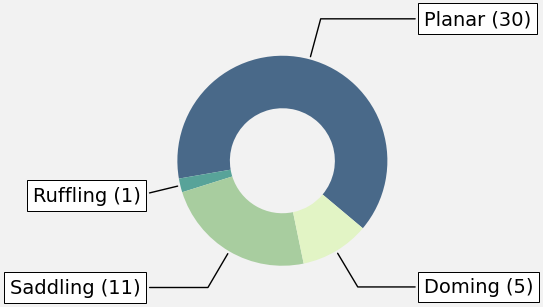

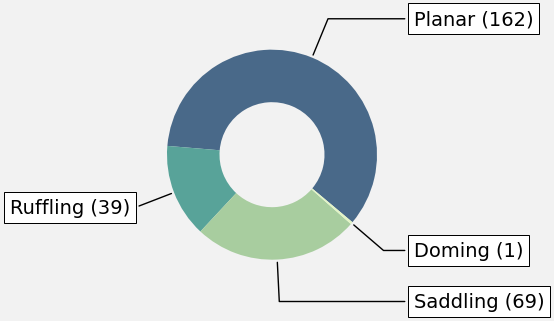

In [110]:
# plotting
for stype, modes in dominant_modes.items():
    categories = list(modes.keys())
    counts = list(modes.values())
    plt.figure(figsize=(6, 3))
    wedges, texts = plt.pie(counts, wedgeprops=dict(width=0.5), startangle=-40)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        plt.annotate("{} ({})".format(categories[i].title(), counts[i]), xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

basic analysis of non planarity metrics vs. HOMA score

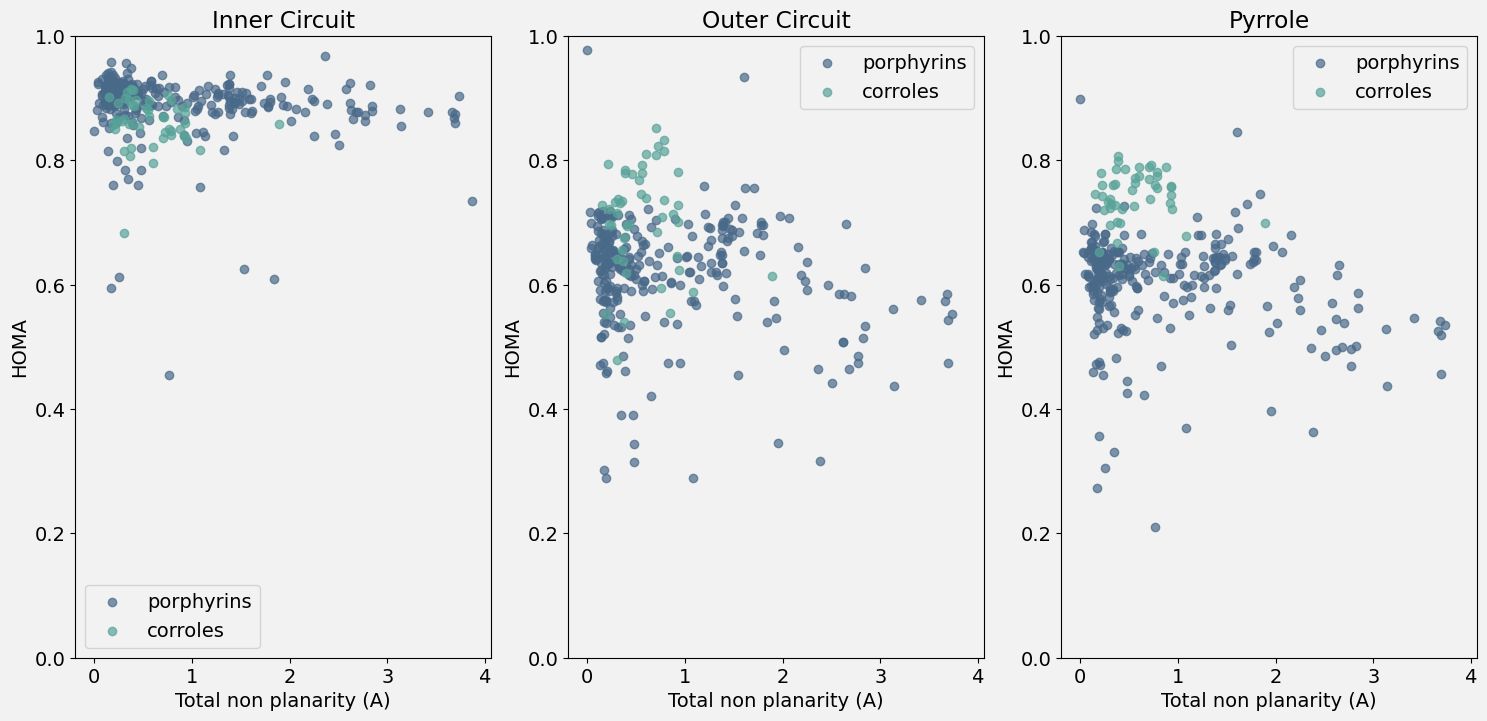

In [114]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 7))
fig.tight_layout()
for ax, col in zip(axs, all_homa.columns):
    ax.scatter(por_abs_np["total out of plane (exp)"], por_homa[col], label="porphyrins", alpha=0.7)
    ax.scatter(cor_abs_np["total out of plane (exp)"], cor_homa[col], label="corroles", alpha=0.7)
    ax.legend()
    ax.set_ylim(0, 1)
    ax.set_xlabel("Total non planarity (A)")
    ax.set_ylabel("HOMA")
    ax.set_title(col.replace("_", " ").title())


plots of HOMA scores vs modes of non planarity

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 7))
fig.tight_layout()
modes = ["saddling non planarity", "ruffling non planarity", "doming non planarity"]
xmax = por_abs_np[modes].max().max()
for i in range(3):
    axs[i, 0].set_ylabel(modes[i].split()[0].title())
    for j in range(3):
        col = all_homa.columns[j]
        scatter_plot(por_abs_np[modes[i]].abs(), por_homa[col], axs[i, j], label="porphyrins", add_fitted_line=True)
        scatter_plot(cor_abs_np[modes[i]].abs(), cor_homa[col], axs[i, j], label="corroles", add_fitted_line=True)
        # axs[i, j].scatter(por_abs_np[modes[i]].abs(), por_homa[col], label="porphyrins", alpha=0.7)
        # axs[i, j].scatter(cor_abs_np[modes[i]].abs(), cor_homa[col], label="corroles", alpha=0.7)
        # axs[i, j].legend()
        axs[i, j].set_ylim(0, 1)
        axs[i, j].set_xlim(0, xmax)
        if i == 0:
            axs[i, j].set_title(col.replace("_", " ").title())
            axs[-1, j].set_xlabel("Absolute non planarity (A)")


a boxplot representation of the non planarity vs HOMA. a clear trend is not visible.

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 7))
fig.tight_layout()
modes = ["saddling non planarity", "ruffling non planarity", "doming non planarity"]
xmax = por_abs_np[modes].max().max()
th = 0.7
for i in range(3):
    axs[i, 0].set_ylabel(modes[i].split()[0].title())
    for j in range(3):
        data = []
        for df in [por_abs_np, cor_abs_np]:
            planar = df[df[modes[i]] <= th].index
            non_planar = df[df[modes[i]] > th].index
            data += [all_homa.loc[planar, all_homa.columns[j]], all_homa.loc[non_planar, all_homa.columns[j]]]
        axs[i, j].boxplot(data)
        axs[i, j].set_ylim(0, 1)
        axs[i, j].set_xticklabels(["Planar", "Not Planar", "Planar", "Not Planar"])
        # axs[i, j].set_xlabel("Total non planarity (A)")
        axs[i, j].set_ylabel("HOMA")
        axs[i, j].set_title(all_homa.columns[j].replace("_", " ").title())

HOMA score components vs non planarity modes

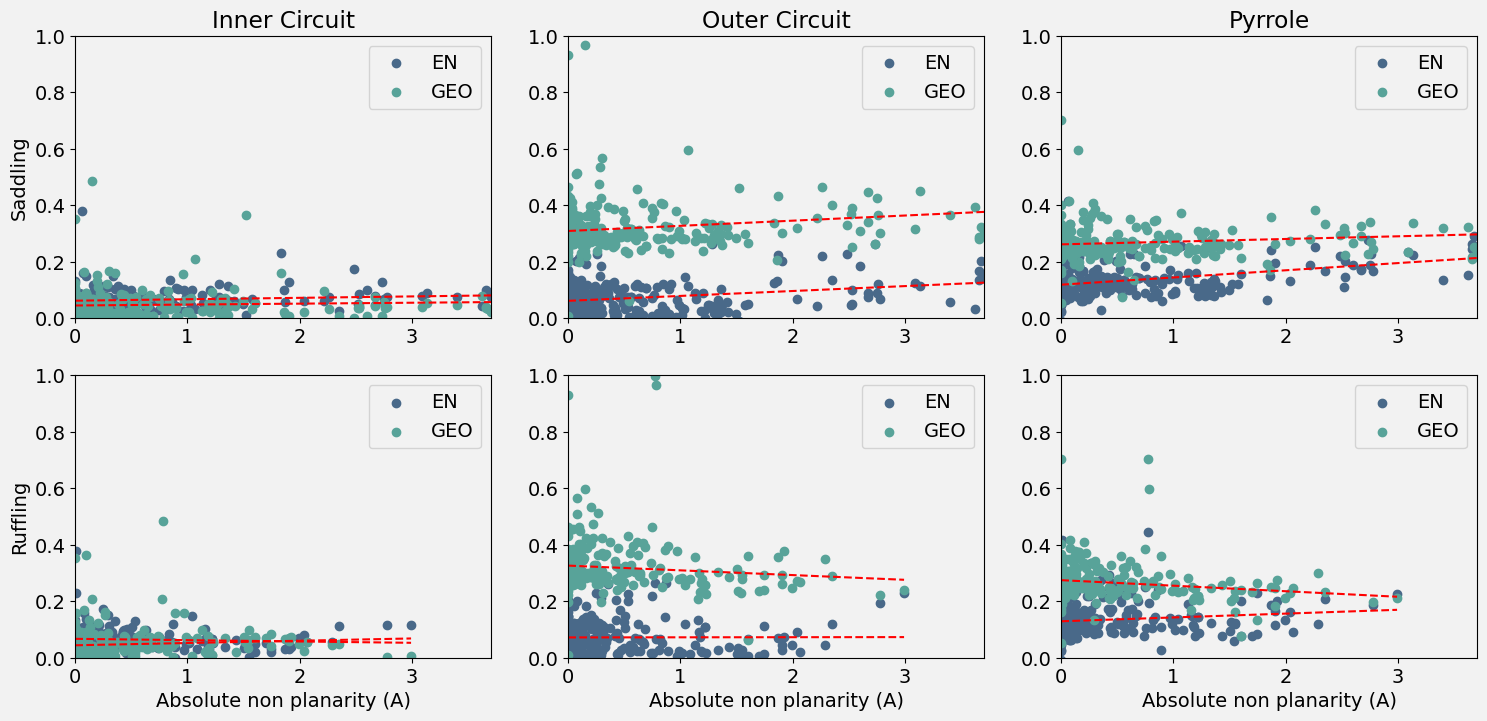

In [164]:
modes = ["saddling non planarity", "ruffling non planarity"]
fig, axs = plt.subplots(nrows=len(modes), ncols=len(all_homa.columns), figsize=(15, 7))
fig.tight_layout()
xmax = por_abs_np[modes].max().max()
for i in range(len(modes)):
    axs[i, 0].set_ylabel(modes[i].split()[0].title())
    for j in range(len(all_homa.columns)):
        col = all_homa.columns[j]
        scatter_plot(por_abs_np[modes[i]].abs(), por_en[col], axs[i, j], label="EN", add_fitted_line=True)
        scatter_plot(por_abs_np[modes[i]].abs(), por_geo[col], axs[i, j], label="GEO", add_fitted_line=True)
        # axs[i, j].scatter(por_abs_np[modes[i]].abs(), por_homa[col], label="porphyrins", alpha=0.7)
        # axs[i, j].scatter(cor_abs_np[modes[i]].abs(), cor_homa[col], label="corroles", alpha=0.7)
        axs[i, j].legend()
        axs[i, j].set_ylim(0, 1)
        axs[i, j].set_xlim(0, xmax)
        if i == 0:
            axs[i, j].set_title(col.replace("_", " ").title())
            axs[-1, j].set_xlabel("Absolute non planarity (A)")


# Model fit

In [6]:
from feature_selection import FEATURIZERS, REGRESSION_TARGETS
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [16]:
featurizer = FEATURIZERS["vdw_distances"]
target = REGRESSION_TARGETS["total_out_of_plane"]
X = featurizer.featurize(session, por_sids)
y = target.featurize(session, por_sids)
model = RandomForestRegressor(n_estimators=1000)


/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprec

Text(0.5, 1.0, 'Test')

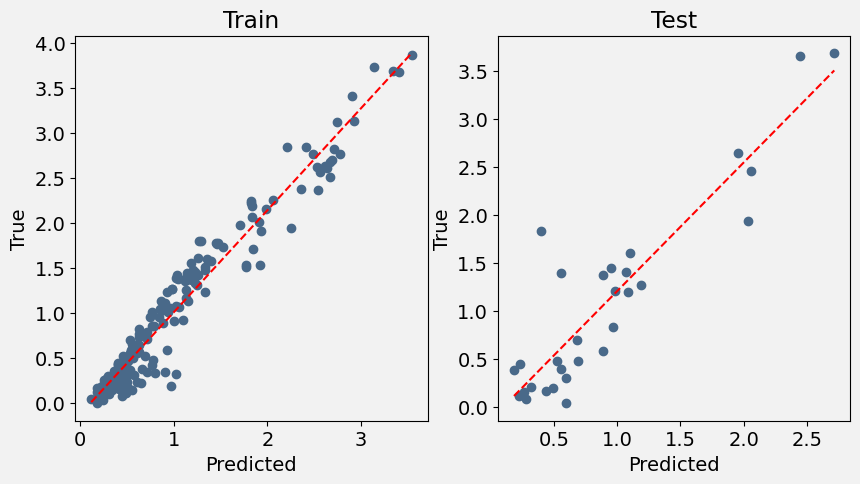

In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=30)
model.fit(xtrain, ytrain)
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
scatter_plot(model.predict(xtrain), ytrain, xname="Predicted", ax=axs[0], yname="True", add_fitted_line=True)
axs[0].set_title("Train")
scatter_plot(model.predict(xtest), ytest, xname="Predicted", ax=axs[1], yname="True", add_fitted_line=True)
axs[1].set_title("Test")